Summary: This is similar to the number of grid cell weights but instead with average time. This is also a more aggragated path to path
# Resulting weights = 
[201.70483660130716
10.166325878594247
-208.83953125000002
-460.87083333333334
-775.0755555555556
-1046.168888888889
-1527.7117647058826]
bins = array([ 250,  550,  850, 1150, 1450, 1750])

In [1]:
import csv
import collections
import pandas as pd
import numpy as np
import math
import json
import matplotlib.pyplot as plt
import seaborn as sns

## load all data

In [2]:
# This is the grid object, which is used throughout all data preprocessing.
# It represents the city of Austin through a series of grids.
# It thus makes a tractable way to compute distance between grids, ect. 
class Grid():
    def __init__(self, grid_json):
        self.grid = grid_json
        self.min_lat = self.grid["latitude_min"]
        self.min_lon = self.grid["longitude_min"]
        self.max_lat = self.grid["latitude_max"]
        self.max_lon = self.grid["longitude_max"]
        self.latitude_delta = self.grid["latitude_step"]
        self.longitude_delta = self.grid["longitude_step"]
        self.nrows = math.ceil((self.max_lat - self.min_lat) / self.latitude_delta)
        self.ncols = math.ceil((self.max_lon - self.min_lon) / self.longitude_delta)
        self.times = self.grid["time_matrix"]
        self.census_tract_region_map = self.grid["census_tract_region_mapping"]
        self.region_to_tract = collections.defaultdict(list)
        for census_tract in self.census_tract_region_map:
            for region in self.census_tract_region_map[census_tract]:
                self.region_to_tract[region].append(census_tract)
    def map_point_to_region(self, latitude, longitude):
        return math.floor((latitude-self.min_lat)/self.latitude_delta) * self.ncols  + math.floor((longitude-self.min_lon)/self.longitude_delta)
    def get_representative(self, region_num):
        row_num = region_num//self.ncols
        col_num = region_num - row_num*self.ncols
        lat = self.min_lat + row_num * self.latitude_delta + 0.5*self.latitude_delta
        lon = self.min_lon + col_num * self.longitude_delta + 0.5*self.longitude_delta
        return [lon, lat]
    def get_time(self, region1, region2):
        try:
            return self.times[region1][region2]
        except IndexError:
            return -1
    def region_to_census_tract(self, region):
        try:
            return self.region_to_tract[region]
        except KeyError:
            return "0_0"

In [3]:
peakHours = (np.genfromtxt("..\Output_Data/peakHours.csv", delimiter=",", dtype = str))

with open("..\Input_Data/grid_info_multiple.json", "r") as f:
    grid_json = json.load(f)
g = Grid(grid_json)

In [4]:
peakHours[0]

array(['', 'IncidentForeignKey', 'Radio_Name', 'Longitude_At_Assign_Time',
       'Latitude_At_Assign_Time', 'Time_Assigned', 'Time_Enroute',
       'Time_ArrivedAtScene', 'Time_Depart_Scene',
       'Time_Arrive_Destination', 'Time_Available', 'Time_Call_Cleared',
       'Call_Disposition', 'Longitude_Of_Emergency',
       'Latitude_Of_Emergency', 'transport_time', 'grid_time'],
      dtype='<U30')

## compare error for time bins

In [5]:
print(peakHours[0,3]) #Longitude_At_Assign_Time
print(peakHours[0,4]) #Latitude_At_Assign_Time
print(peakHours[0,5]) #Time_Assigned
print(peakHours[0,6]) #Time_Enroute
print(peakHours[0,7]) #Time_ArrivedAtScene
print(peakHours[0,8]) #Time_Depart_Scene
print(peakHours[0,9]) #Time_Arrive_Destination
print(peakHours[0,10]) #Time_Available
print(peakHours[0,11]) #Time_Call_Cleared
print(peakHours[0,13]) #Longitude_Of_Emergency
print(peakHours[0,14]) #Latitude_Of_Emergency
print(peakHours[0,15]) #travel_time
print(peakHours[0,16]) #grid_time

Longitude_At_Assign_Time
Latitude_At_Assign_Time
Time_Assigned
Time_Enroute
Time_ArrivedAtScene
Time_Depart_Scene
Time_Arrive_Destination
Time_Available
Time_Call_Cleared
Longitude_Of_Emergency
Latitude_Of_Emergency
transport_time
grid_time


In [88]:
#weight object
bins = np.arange(250,2000,300) #start,stop interval
weights = [[] for i in range(bins.shape[0] + 1)]

In [95]:
bins

array([ 250,  550,  850, 1150, 1450, 1750])

In [90]:
weights[0]

[]

In [91]:
def gridTime2Bin(grid_time):
    for i in range(bins.shape[0]):
        if(grid_time < bins[i]):
            return (i)
    return bins.shape[0]

In [92]:
#running the verification on "training data" to determine weights
nsamples = 1000 #len(peakHours)
error_list = []
error_percent = []
grid_list = []
report_list = []
for i in range(1,nsamples):
    start_pt = g.map_point_to_region(float(peakHours[i,4]),float(peakHours[i,3]))
    end_pt = g.map_point_to_region(float(peakHours[i,14]),float(peakHours[i,13]))
    grid_time = g.get_time(start_pt,end_pt)
    reported_time = float(peakHours[i,15])
    grid_list.append(grid_time)
    report_list.append(reported_time)

    #print(str(grid_time) + " " + str(gridTime2Bin(grid_time))) #debug
    weights[gridTime2Bin(grid_time)].append(reported_time -  grid_time)
    
    error_list.append(reported_time -  grid_time)
    #error percent
    if(grid_time > reported_time):
        error_percent.append(grid_time/reported_time - 1)
    else: #grid_time <= reported_time
        error_percent.append(-1 * (1 - grid_time/reported_time))

201.70483660130716
10.166325878594247
-208.83953125000002
-460.87083333333334
-775.0755555555556
-1046.168888888889
-1527.7117647058826


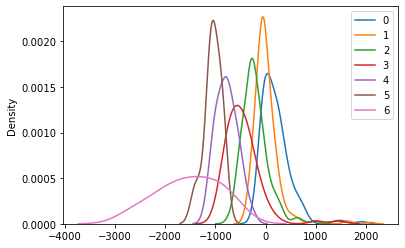

In [94]:
for i in range(bins.shape[0] + 1):
    print(np.mean(weights[i]))
for i in range(bins.shape[0] + 1):
    sns.kdeplot(weights[i], label=str(i))
    plt.legend()
    

-146.8555955955956


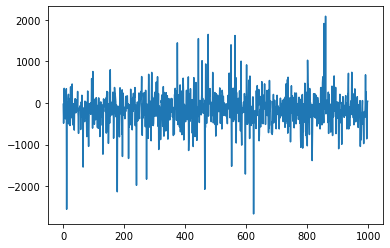

In [14]:
print(np.mean(error_list))
plt.plot(error_list)

1.8048832749599404
24.99134113626784


(-5.0, 0.0)

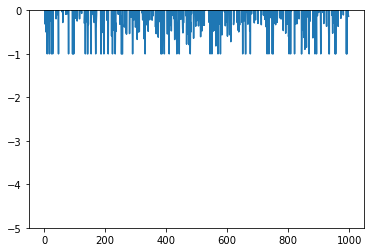

In [28]:
print(np.mean(error_percent))
print(np.std(error_percent))
plt.plot(error_percent)
plt.ylim((-5,0))


2.062205423408877
1.8048832749599404
24.99134113626784
747.64


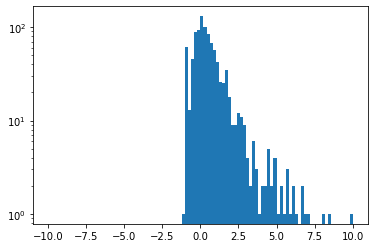

In [24]:
#plt.hist(error_list, bins = 100, log = True)
a = plt.hist(error_percent, bins = 100, range = (-10,10), log = True)
print(np.mean(np.abs(error_percent)))
print(np.mean(error_percent))
print(np.std(error_percent))
print(np.max(np.abs(error_percent)))